# Graphical user interface to label pixels with a common numerical value in Sentinel-2 multispectral images using the Sentinel Hub distribution platform

This notebook facilitates the rapid labelling of pixels with a fixed numerical value on individual Sentinel-2 scenes obtained with Sentinel Hub's WMS and WCS services ([sentinelhub-py python package](https://github.com/sentinel-hub/sentinelhub-py)) using a GUI.  

**Works only in conjunction with a valid Sentinel Hub subscription with OGC-standard WMS and WCS access.** See information on [pricing plans, a 30-day free trial and free research accounts](https://www.sentinel-hub.com/pricing-plans).

Bence Mélykúti, DPhil (Oxf)  
2019-2020

## Prerequisite: Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, you can create one (for a 30-day free trial) on the [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). 

Once you have the account set up, create a configuration with Sentinel-2 Level-1C (L1C) or Level-2A (L2A). Enter your **_instance ID_** (alpha-numeric code of length 36) in the appropriate cell below.

For LAYER_NAME_TCI, enter the ID of the true colour channel, e.g. "TRUE_COLOR".  
The pixel values actually saved are the bands defined in the variable `bands_script`.

#### Imports

cf. https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-reload_ext  
https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html  
https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-matplotlib

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
#matplotlib.use('agg') # https://github.com/gboeing/osmnx/issues/75
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json, os, time
from datetime import datetime, timedelta
from sentinelhub import WcsRequest, BBox, CRS, MimeType, CustomUrlParam, get_area_dates, DataSource
import tkinter as tk
from PIL import Image, ImageTk

from utils.plotting import plot_image, plot_image_pair, plot_previews
from utils.downloading import SH_TCI_retrieve, SH_TCI_retrieve_successor, SH_bands_retrieve, download_pixel_vectors
from utils.utils import *
from utils.gui import BigFrame

#### User input

In [3]:
level_choice = 'L2A' # Choose 'L1C' or 'L2A'.

if level_choice == 'L1C':
    INSTANCE_ID = 'xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx' # Level-1C configuration instance ID
    LAYER_NAME_TCI = 'TRUE_COLOR'
    LAYER_NAME_BANDS = LAYER_NAME_TCI
    DATA_SOURCE = DataSource.SENTINEL2_L1C
else: # i.e. 'L2A'
    INSTANCE_ID = 'xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx' # Level-2A configuration instance ID
    LAYER_NAME_TCI = 'TRUE_COLOR'
    LAYER_NAME_BANDS = LAYER_NAME_TCI
    DATA_SOURCE = DataSource.SENTINEL2_L2A

In [4]:
# We list all bands except for B10. Band 10 is the cirrus band and it does not contain
# surface information. Level-2A products don't even contain it.
bands_of_interest = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
bands_script = 'return [B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]'
# Specify the colour of selected pixels with RGB values from 0 to 255.
#colour_for_selection = [0, 0, 0] # black
colour_for_selection = [192, 0, 192] # magenta stands out from naturally occurring colours

In [5]:
# Specify your output folder or just use the default, timestamped folder name.
launch_timestamp = time.strftime('%Y%m%d_%Hh%Mm%S', time.localtime(time.time()))
output_folder = 'labelled_data_' + level_choice + '_' + launch_timestamp
print(output_folder)

labelled_data_L2A_20200211_14h04m27


## User guide

The labelling workflow has three steps:

1. **Initialisation** Selection of scene, start date, name of scene, numerical value of label, and possibly the initial selection of pixels.

2. **Selecting pixels** Going through all available images of the selected scene from start date until the present, selecting pixels for retrieval, and saving pixel selection in a JSON file.

3. **Downloading pixel values** Opens the JSON file that was generated in Step&nbsp;2, and following its instructions downloads the scene for all listed dates and saves the selected pixel values from the selected bands into a CSV file. This might take several minutes and works without intervention.

## 1. Initialisation

Select scene by the dictionary `locations`, modelled on the examples.  
Specify a bounding box for the area of interest by its southwest corner in WGS84 and two side lengths (measured also in degrees in WGS84). As of `sentinelhub` version 2.0.0, the order of coordinates for BBOX in WGS84 has to be given in longitude, latitude order.

- `bl` is East, North coordinates of southwest corner ("bottom left") of bounding box in WGS84.
- `sl` is side lengths of the bounding box (long, lat) in degrees in WGS84 (like above).
- `px` is an np.array (size: 2 x nr_of_pixels) of pixels in image coordinates. This is the initial state of the pixel set to be read out ((row, column) indices). Using the GUI, you can change this set image by image. It can be set to `ep`, the empty array.
- `label` is your label value for the pixels you are selecting (e.g. use the scale [0; 1]).
- `date` is a single date in 'YYYY-MM-DD' format; images will be served starting with the first available date not earlier than `date` and the GUI will offer all captures one by one until present.
- `name` is a string to identify place with a place name. The output file name is based on this.

**Note**  
The Sentinel Hub platform makes [the following products available](https://docs.sentinel-hub.com/api/latest/#/data/):

- Sentinel-2 Level-1C: Global since November 2015
- Sentinel-2 Level-2A: Europe since March 2017 & Global since December 2018

In [7]:
locations = dict()
ep = np.array([[],[]]) # For empty px; otherwise it's rows, columns like matrix indexing (i.e. first y then x).
#locations[]['px'] = np.array([[],\[]]) # Template.

# Accra beach near Jamestown Lighthouse, Accra, Ghana (on land) -- For L2A, Sentinel Hub has data from 2018-12-13 only!
locations[0]={'bl': [-0.216186, 5.530283], 'sl': [0.012, 0.004], 'date': '2018-12-13', 'label': 0.2, 'name': 'Accra beach near Jamestown Lighthouse, Ghana'}
locations[0]['px'] = np.array([[29, 29, 29, 28, 27, 27, 27, 27, 27, 26, 26, 25, 24, 24, 24, 24, 23, 22, 22, 21, 21],\
                               [17, 22, 29, 25, 26, 31, 37, 42, 45, 33, 53, 40, 35, 43, 50, 57, 47, 51, 60, 53, 57]])
locations[1]=locations[0].copy(); locations[1]['date'] = '2019-06-03'

# Ghazipur landfill, New Delhi, India -- For L2A, Sentinel Hub has data from 2018-12-13 only!
locations[2]={'bl': [77.3245, 28.6215], 'sl': [0.006, 0.006], 'date': '2018-12-16', 'label': 0.67, 'name': 'Ghazipur landfill, New Delhi, India'}
locations[2]['px'] = np.array([[64, 65, 64, 58, 58, 58, 58, 50, 51, 50, 51, 50, 40, 40, 40, 41, 40, 41, 33, 32, 33, 32, 33, 32, 33, 27, 26, 27, 26, 27, 20, 20, 20, 20],\
                               [13, 20, 27, 10, 17, 24, 30,  3, 10, 18, 27, 35,  5, 12, 18, 26, 34, 42,  1,  7, 13, 19, 25, 31, 37, 13, 19, 25, 31, 37, 22, 28, 34, 40]])
locations[3]=locations[2].copy(); locations[3]['date'] = '2019-06-04'

# Kamilo Beach, Naalehu, Hawaii, USA (Trash Beach, Plastic Beach, overwhelmed with human refuse, https://www.miamiherald.com/news/nation-world/national/article231166578.html)
locations[4]={'bl': [-155.6108, 18.965], 'sl': [0.015, 0.008], 'date': '2019-06-07', 'label': 0.33, 'name': 'Kamilo Beach, Naalehu, Hawaii, USA'}
locations[4]['px'] = np.array([[80, 79, 78, 78, 77, 77, 77, 75, 75, 74, 74, 72, 70, 70, 69, 68, 67, 66, 65, 64, 64, 62, 62, 60, 58, 55, 54, 54, 54, 52, 52, 50, 50, 47, 47, 44, 40, 32, 32, 32, 30, 28, 26, 24],\
                               [ 5, 12,  2,  8, 12, 16, 20,  3,  9, 12, 18, 20, 18, 26, 21, 28, 23, 31, 26, 24, 30, 27, 33, 31,115,110,120,126,132,116,122,112,118,115,122,120,118,114,120,126,122,128,135,125]])
locations[5]=locations[4].copy(); locations[5]['date'] = '2019-05-03'

# Pohoiki Beach, Hawaii, USA (freshly created by lava in July 2018, microplastic detected in 2019; https://www.miamiherald.com/news/nation-world/national/article231166578.html)
# 2018-05-03 shows the old situation well (on Sentinel Hub L1C only), 2019-01-03 the new.
#locations[6]={'bl': [-154.8427091, 19.4574578], 'sl': [0.015, 0.008], 'date': '2019-06-07', 'px': ep, 'label': 0}
#locations[6]={'bl': [-154.844473, 19.455277], 'sl': [0.008, 0.008], 'date': '2019-01-03', 'label': 0, 'name': 'Pohoiki Beach, Hawaii, USA'}
locations[6]={'bl': [-154.844473, 19.455277], 'sl': [0.015, 0.012], 'date': '2019-01-03', 'label': 0, 'name': 'Pohoiki Beach, Hawaii, USA'}
#locations[6]['px'] = np.array([[73, 73, 72, 72, 72, 72, 71, 71, 71, 70, 70, 69, 69, 69, 68, 68, 68, 67, 67, 67, 66, 66, 65, 65, 64, 64, 64, 63, 62, 62, 60, 60],\
#                               [42, 45, 38, 40, 47, 49, 36, 43, 53, 39, 48, 34, 50, 56, 36, 42, 53, 39, 47, 57, 50, 60, 43, 54, 48, 56, 62, 45, 52, 62, 56, 66]])
locations[6]['px'] = np.array([[9, 20, 24, 35, 47, 30, 55, 66, 80, 92, 104, 113, 90, 70, 49, 49, 74, 84, 96, 112, 114, 115, 114, 111, 108, 100, 99, 95, 90, 86, 77, 68, 57, 49, 47, 44, 41, 44, 40, 41, 40, 107, 109, 101, 106, 98, 102, 100, 97, 90, 97, 93, 87, 79, 87, 85, 72, 78, 68, 72, 65, 62, 69, 56, 59, 63, 51, 53, 52, 44, 38, 40, 34, 37, 35, 32, 30, 31, 28, 32, 34, 40, 49, 58, 63, 69, 62, 82, 84, 76, 44, 51, 37, 41, 28, 31, 26, 19, 23, 13, 15, 22, 25, 41, 34, 28, 22, 30, 15, 19, 19, 12, 19, 10, 24, 33, 39, 57, 64, 58, 64, 70, 75, 83, 90, 78, 76, 22, 13, 15, 19, 10, 9, 11, 35, 37, 46, 54, 110, 107, 96, 96, 92, 85, 81, 72, 82, 93, 98, 101, 103, 109, 111, 55, 63, 43, 42],\
                               [151, 147, 117, 128, 103, 85, 67, 83, 92, 77, 64, 46, 46, 45, 57, 85, 65, 77, 58, 39, 42, 50, 53, 57, 61, 77, 83, 90, 95, 98, 104, 111, 116, 122, 114, 119, 133, 127, 140, 147, 152, 42, 49, 48, 54, 54, 57, 67, 65, 69, 72, 84, 81, 85, 88, 93, 93, 97, 99, 101, 107, 101, 105, 104, 108, 111, 108, 111, 117, 111, 118, 123, 136, 142, 150, 143, 152, 147, 135, 122, 111, 103, 92, 94, 74, 58, 57, 51, 62, 74, 67, 78, 77, 92, 99, 106, 126, 132, 141, 146, 138, 153, 108, 83, 72, 79, 92, 92, 108, 99, 117, 121, 124, 132, 69, 64, 59, 60, 67, 82, 91, 75, 84, 69, 54, 59, 53, 78, 81, 92, 84, 98, 113, 103, 89, 98, 97, 98, 53, 58, 76, 81, 89, 85, 97, 107, 101, 93, 87, 73, 69, 64, 60, 121, 115, 131, 144]])

# Reynisfjara Beach, Iceland (black sand)
locations[7]={'bl': [-19.098, 63.402], 'sl': [0.016, 0.008], 'date': '2019-06-06', 'label': 0, 'name': 'Reynisfjara Beach, Iceland'}
locations[7]['px'] = np.array([[25, 25, 25, 25, 27, 27, 30, 30, 30, 31, 31, 32, 33, 33, 34, 34, 36, 38, 40, 40, 40, 42, 42, 42],\
                               [ 5, 11, 17, 25, 30, 40,  2,  8, 14,  5, 11,  7,  3, 30,  7, 36,  9,  6,  4, 10, 25,  6, 15, 30]])
locations[8]=locations[7].copy(); locations[8]['date'] = '2018-10-17'
locations[9]=locations[7].copy(); locations[9]['date'] = '2019-05-04'

# sand mine between York and Taylor, Wisconsin, USA
locations[10]={'bl': [-91.146060, 44.354184], 'sl': [0.016, 0.005], 'date': '2019-05-04', 'label': 0, 'name': 'sand mine between York and Taylor, Wisconsin, USA'}
locations[10]['px'] = np.array([[10, 10, 10, 15, 15, 15, 17, 18, 17, 18, 18, 23, 23, 23, 27, 27, 35, 35, 40, 40, 43, 43, 54, 54, 54],\
                                [52, 59, 65, 43, 56, 66,  2,  8, 14, 48, 60, 50, 57, 67, 55, 62, 73, 83, 28, 80, 35, 74, 74, 85, 93]])
locations[11]=locations[10].copy(); locations[11]['date'] = '2019-01-09'
locations[12]=locations[10].copy(); locations[12]['date'] = '2018-12-30' # bit of snow

# sand mine near Gánt, Hungary (Dolomit Kft.)
locations[13]={'bl': [18.391132, 47.354945], 'sl': [0.012, 0.012], 'date': '2019-02-07', 'label': 0, 'name': 'sand mine near Gánt, Hungary'}
locations[13]['px'] = np.array([[10, 12, 14, 14, 14, 14, 16, 16, 18, 20, 20, 20, 30, 30, 40, 40, 40, 45, 45, 45, 45, 50, 50, 50, 55, 55, 55, 65, 65, 65],\
                                [30, 35, 28, 34, 40, 50, 45, 55, 27, 33, 44, 55, 30, 60, 35, 45, 60, 23, 38, 48, 58, 40, 50, 60, 42, 52, 62, 35, 45, 60]])
locations[14]=locations[13].copy(); locations[14]['date'] = '2019-04-20'
locations[15]=locations[13].copy(); locations[15]['date'] = '2018-08-16'

# Pata-Rat landfill near Cluj, Romania
locations[16]={'bl': [23.684858, 46.762694], 'sl': [0.006, 0.006], 'date': '2018-08-20', 'label': 0.67, 'name': 'Pata-Rat landfill near Cluj, Romania'}
locations[16]['px'] = np.array([[20, 20, 25, 25, 25, 29, 30, 29, 35, 34, 35, 34, 40, 40, 40, 40, 45, 46, 45, 46, 50, 51, 50, 51, 53, 54, 53, 58, 58, 58, 57, 63, 62, 63, 61],\
                                [16, 23, 14, 19, 24, 15, 20, 15, 12, 18, 23, 27, 10, 16, 22, 27,  8, 14, 21, 28, 12, 19, 24, 29, 15, 22, 26, 12, 19, 24, 29, 15, 20, 25, 31]])
locations[17]=locations[16].copy(); locations[17]['date'] = '2019-02-16'
locations[18]=locations[16].copy(); locations[18]['date'] = '2019-03-05'
locations[19]=locations[16].copy(); locations[19]['date'] = '2019-05-19'

# greenhouses in El Ejido, Almería, Spain
locations[20]={'bl': [-2.771250, 36.722165], 'sl': [0.01, 0.006], 'date': '2019-04-11', 'label': 1, 'name': 'greenhouses in El Ejido, Almería, Spain'}
locations[20]['px'] = np.array([[1,  1,  1,  2,  2,  2,  2, 10, 10, 10, 20, 20, 30, 30, 35, 35, 35, 40, 40, 45, 48, 48, 48, 48, 50, 50, 52, 52, 52, 55, 55, 55, 60, 60, 60, 64, 64],\
                                [6, 12, 18, 26, 33, 41, 49, 36, 45, 65, 72, 82,  9, 50,  9, 20, 50, 29, 50, 55,  5, 12, 20, 50,  8, 16,  6, 13, 21,  8, 16, 24,  8, 16, 24, 22, 30]])
locations[21]=locations[20].copy(); locations[21]['date'] = '2018-12-22'
locations[22]=locations[20].copy(); locations[22]['date'] = '2018-11-07'
locations[22]['px'] = np.array([[1,  1,  1,  2,  2,  2,  2, 10, 10, 10, 20, 20, 28, 29, 30, 30, 35, 35, 35, 40, 40, 45, 48, 48, 48, 48, 50, 50, 52, 52, 52, 55, 55, 55, 60, 60, 60, 64, 64],\
                                [6, 12, 18, 26, 33, 41, 49, 36, 45, 65, 72, 66, 21, 15,  9, 50,  9, 20, 50, 29, 50, 55,  5, 12, 20, 50,  8, 16,  6, 13, 21,  8, 16, 24,  8, 16, 24, 22, 30]])

# greenhouses near San Pedro del Pinatar, at the border of Valencia & Murcia, Spain
locations[23]={'bl': [-0.823238, 37.862753], 'sl': [0.01, 0.006], 'date': '2019-04-11', 'label': 1, 'name': 'greenhouses near San Pedro del Pinatar, Spain'}
locations[23]['px'] = np.array([[ 2,  2,  3,  2,  3,  8,  6,  7, 15, 15, 15, 15, 15, 19, 20, 21, 21, 20, 20, 30, 35, 35, 33, 32, 35, 38, 38, 40, 40, 40, 42, 42, 44, 45, 45, 46, 48, 49, 50, 50, 56, 56, 58, 58, 58, 62],\
                                [26, 38, 42, 62, 66, 36, 51, 62, 13, 25, 42, 54, 73, 17, 25, 30, 47, 53, 75, 16,  2, 10, 22, 37, 41, 14, 20,  4, 17, 45, 12, 18, 15, 11, 42, 14, 13, 10, 24, 33, 27, 75, 72, 78, 84, 84]])
locations[24]=locations[23].copy(); locations[24]['date'] = '2018-12-22'
locations[25]=locations[23].copy(); locations[25]['date'] = '2018-11-07'

# whiter greenhouses near San Pedro del Pinatar, at the border of Valencia & Murcia, Spain
locations[26]={'bl': [-0.823270, 37.857546], 'sl': [0.01, 0.006], 'date': '2019-04-11', 'label': 1, 'name': 'whiter greenhouses near San Pedro del Pinatar, Spain'}
locations[26]['px'] = np.array([[23, 23, 25, 25, 27, 28, 27, 28, 29, 30, 30, 30, 30, 30, 32, 32, 32, 35, 35, 35, 35, 38, 38, 38, 40, 40, 40, 40, 46, 48, 48, 50, 52, 52, 55, 55, 55, 57, 57, 57, 59, 59, 62, 62, 64, 64],\
                                [42, 47, 44, 51, 40, 47, 57, 62, 43, 38, 49, 54, 60, 69, 45, 57, 65, 52, 58, 65, 72, 54, 62, 68, 35, 45, 55, 65, 15, 12, 18, 22, 17, 25, 20, 28, 44, 16, 22, 48,  7, 27,  5, 28,  3, 10]])
locations[27]=locations[26].copy(); locations[27]['date'] = '2018-12-22'
locations[28]=locations[26].copy(); locations[28]['date'] = '2018-11-07'

# Snow
# Vanyola, Hungary
locations[29]={'bl': [17.585674, 47.397421], 'sl': [0.01, 0.006], 'date': '2019-01-13', 'label': 0, 'name': 'snow near Vanyola, Hungary'}
locations[29]['px'] = np.array([[3, 10,  6,  8, 15, 18, 21, 25, 24, 12, 13, 20, 30, 30, 36, 37, 36, 37, 40, 45, 49, 50, 50, 58, 55, 36, 38, 44, 44, 45, 51, 51, 51, 51, 56, 56, 56, 57, 56, 57, 62, 64, 62, 64, 62, 64, 62, 64, 63],\
                                [3,  1, 15, 22, 15, 17, 20, 24, 31, 25, 31, 35, 45, 53, 28, 36, 60, 67, 50, 65, 58, 45, 70, 50, 65,  5, 12,  3, 12, 20,  6, 16, 25, 38,  1, 10, 20, 28, 34, 40,  4, 13, 25, 31, 37, 43, 52, 60, 67]])
# Valkó, Hungary
locations[30]={'bl': [19.463803, 47.543785], 'sl': [0.01, 0.006], 'date': '2018-02-19', 'label': 0, 'name': 'snow near Valkó, Hungary'}
locations[30]['px'] = np.array([[ 2,  2,  2,  2,  4,  8,  8,  8,  8, 12, 12, 12, 19, 19, 19, 25, 25, 25, 25, 25, 25, 25, 25, 30, 30, 30, 30, 30, 30, 30, 30, 35, 35, 35, 35, 35, 36, 36, 36, 42, 42, 42, 42, 48, 48, 48, 48, 48, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61],\
                                [34, 40, 46, 54, 11, 37, 44, 51, 58, 10, 17, 24,  8, 15, 22,  1,  8, 15, 22, 30, 59, 66, 73,  4, 11, 18, 25, 32, 55, 62, 69, 10, 16, 22, 29, 37, 48, 55, 62, 25, 46, 54, 62,  2,  8, 16, 24, 32,  4, 11, 18, 28, 35, 43, 50, 56, 62, 71, 12, 19, 26, 33, 40, 47, 54, 61, 67, 72]])

# Cloud
# Valkó, Hungary
locations[31]=locations[30].copy(); locations[31]['date'] = '2019-01-13'; locations[31]['name'] = 'cloud near Valkó, Hungary'
locations[32]=locations[31].copy(); locations[32]['date'] = '2018-12-31';
locations[33]=locations[31].copy(); locations[33]['date'] = '2018-12-24';

# Lignite mine near Visonta, Hungary, west of Detk
#locations[34]={'bl': [20.048500, 47.735945], 'sl': [0.01, 0.006], 'date': '2020-01-05', 'label': 0, 'name': 'lignite mine near Visonta, Hungary west of Detk'}
locations[34]={'bl': [20.048500, 47.735945], 'sl': [0.02, 0.01], 'date': '2020-01-05', 'label': 0, 'name': 'lignite mine near Visonta, Hungary, west of Detk'}
locations[34]['px'] = ep

# Downtown Budapest, clear sky: '2019-04-25' & '2019-09-05', dramatic clouds: '2019-11-01', rainbows: '2019-11-06'
locations[35]={'bl': [19.0353245, 47.5018083], 'sl': [0.015, 0.01], 'date': '2019-11-06', 'label': 0, 'name': 'Budapest, Hungary'}
locations[35]['px'] = np.array([[51, 52, 55, 54, 53, 45, 45, 45, 45, 45, 48, 48, 46, 47, 46, 47, 48, 49, 50, 51, 49, 49, 52, 53, 54, 48, 49, 50, 51, 52, 53, 54, 55, 55, 55, 55, 55, 52, 53, 53, 53, 52, 52, 53, 54, 55, 52, 54, 55, 55, 55, 53, 52, 53, 52, 55, 55, 52, 53, 54, 52, 53, 54, 56, 55, 54, 53, 52, 52, 54, 55, 55, 54, 53, 52, 55, 54, 53, 51, 52, 55, 53, 54, 55, 55, 52, 52, 53, 54, 52, 55, 54, 51, 51, 52, 53, 54, 55, 55, 53, 48, 49, 49, 49, 47, 46, 45, 45, 45, 47, 47, 47, 48, 48, 47, 46, 46, 47, 45, 46, 47, 46, 49, 48, 48, 49, 45, 46, 46, 45, 45, 46, 47, 48, 49, 50],\
                                [67, 67, 65, 61, 64, 75, 76, 77, 78, 79, 76, 78, 74, 73, 80, 81, 82, 82, 82, 82, 76, 78, 82, 81, 80, 72, 72, 72, 72, 72, 73, 74, 75, 76, 77, 78, 79, 75, 76, 77, 78, 79, 68, 67, 67, 68, 65, 65, 64, 62, 61, 61, 61, 62, 62, 58, 57, 57, 59, 59, 58, 57, 57, 57, 55, 55, 55, 54, 53, 53, 53, 54, 51, 51, 50, 50, 49, 49, 51, 51, 51, 47, 47, 47, 46, 47, 45, 45, 45, 43, 43, 43, 41, 42, 41, 41, 41, 41, 42, 42, 42, 41, 42, 43, 42, 42, 42, 41, 43, 52, 53, 51, 52, 51, 50, 53, 48, 48, 49, 49, 49, 52, 51, 50, 49, 50, 52, 50, 51, 50, 53, 54, 54, 53, 52, 51]])

Verify your choice by visualisation.

In [8]:
# Select key from locations:
k = 35 # index for the dictionary locations
modify_date = False # If False, then use exact date from locations. If True, then
# set in the next cell a start date from which it scans until the first available date.

No. of images available: 2, namely
2019-11-01 09:47:33;  2019-11-01 09:47:36.
Image size: (111, 113, 3).


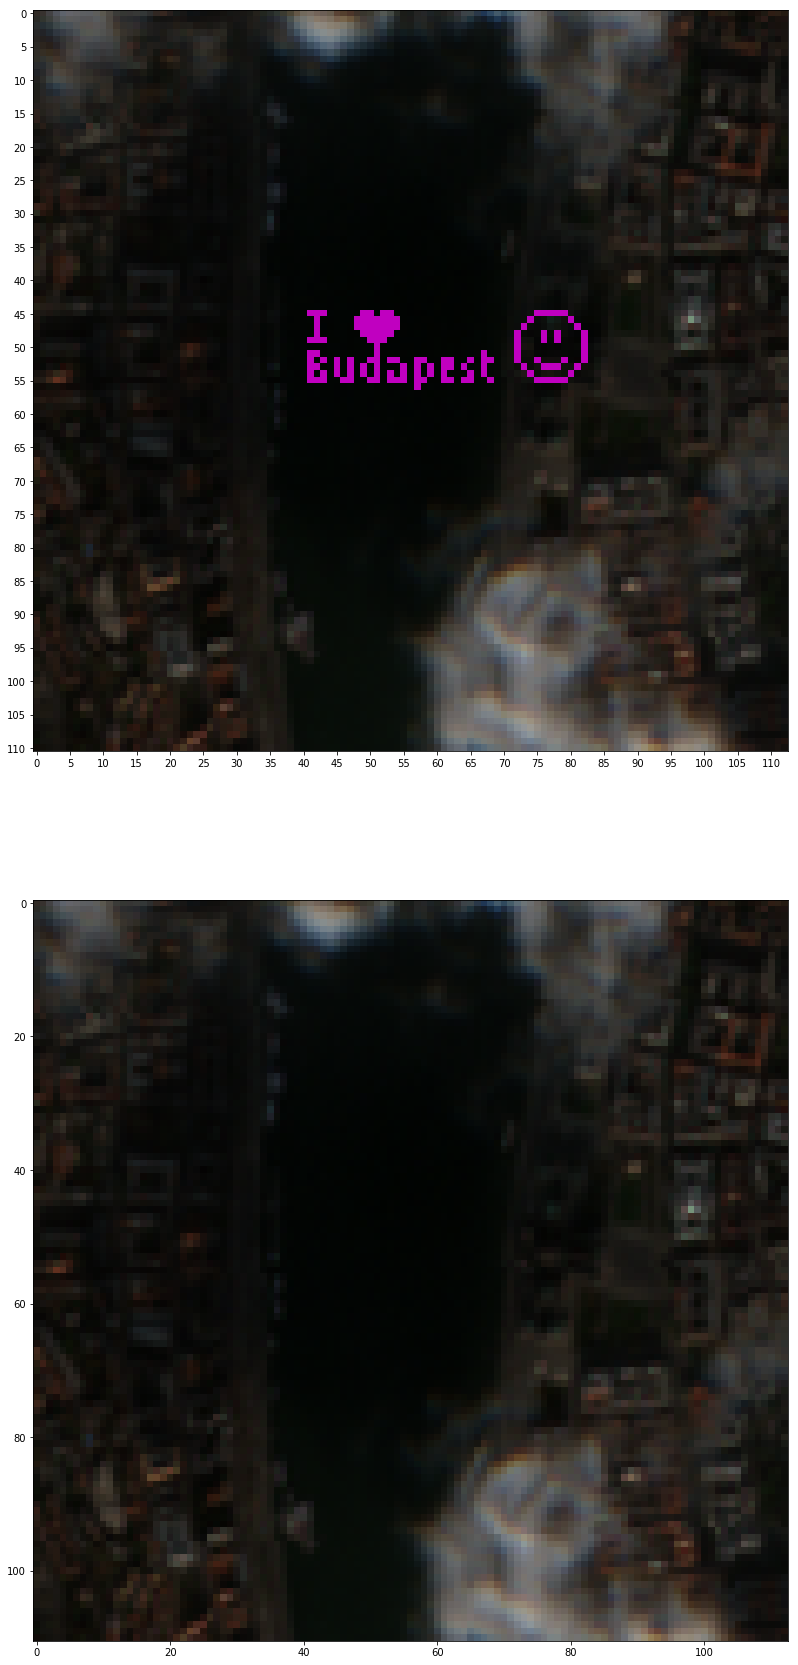

In [9]:
loca = locations[k].copy()
if modify_date==False:
    wms_true_color_imgs, available_dates = SH_TCI_retrieve(loca, INSTANCE_ID, LAYER_NAME_TCI, DATA_SOURCE)
else:
# If you want to modify the date, then set this:
    loca['date'] = '2018-05-03' 
    wms_true_color_imgs, available_dates = SH_TCI_retrieve_successor(loca, INSTANCE_ID, LAYER_NAME_TCI, DATA_SOURCE)

print('No. of images available: {0}, namely'.format(len(wms_true_color_imgs)))
print(''.join([datetime.strftime(d, '%Y-%m-%d %H:%M:%S;  ') for d in available_dates])[:-3]+'.')
print('Image size: {0}.'.format(wms_true_color_imgs[0].shape))

# Plots all images for the given date if there are multiple.
#plot_previews(np.asarray(wms_true_color_imgs), available_dates, cols=2, figsize=(15,10))
# Large plot of the image.
#plot_image(wms_true_color_imgs[0])
# Plots the image with selected pixels marked (top) and the original image (bottom).
plot_image_pair(wms_true_color_imgs[0], loca['px'], colour_for_selection, 1)

## 2. Selecting pixels

### Sequential labelling of images using the graphical user interface

From your preferred start date the GUI will progress through all dates until the present.

Click on pixels to select or deselect them. Once done, select action:

* `Skip` if you want to reject an image (e.g. when it is cloudy) and continue with image from next available date.
* `Save & Continue` for saving pixels and continuing with image from next available date.
* `Save & Quit` for saving pixels and quitting the GUI.
* `Cancel` to quit without saving pixels from the last image.

Wait patiently for the new image to load.

This part of the program saves the pixel locations in a JSON file in the chosen `output_folder`. The file name is generated from `location[key]['name']`.  
**Warning:** The GUI overwrites the content of the file if it already existed. Its output is always all pixel selections from all images from the current GUI run.

If the GUI crashes during a run, then rename its output file, set the start date `loca['date']` to the date where you left off and continue. When you're done, then copy the content of the first output file to the beginning of the second file.

In [11]:
# Select key from locations:
k = 35 # index for the dictionary locations
modify_date = False # If False, then use exact date from locations. If True, then
# set in the next cell a start date from which it scans until the first available date.

magnification=7 # This sets in the GUI the side length of one image pixel, measured in screen pixels.
# For a small scene you can set it to higher, for a large scene you must set it to smaller.

In [20]:
# This cell starts the GUI.
location = locations[k].copy()
if modify_date==True:
# If you want to modify the date, then set this:
    #location['date'] = '2018-05-03'

    #location['date'] = '2017-01-01' # for Level-2A, European scenery, https://docs.sentinel-hub.com/api/latest/#/data/
    #location['date'] = '2018-09-10' # for Level-2A scenery outside of Europe
    location['date'] = '2020-01-13'
root = BigFrame(location, INSTANCE_ID, LAYER_NAME_TCI, DATA_SOURCE, magnification,
                colour_for_selection, output_folder, level_choice)
root.title('sh-pixel-labelling')
root.mainloop()

Next available dates:  ['2019-11-01 09:47:33', '2019-11-01 09:47:36', '2019-11-04 09:57:29', '2019-11-04 09:57:33', '2019-11-06 09:47:30', '2019-11-06 09:47:33']
Skipping 2019-11-01
Next available dates:  ['2019-11-04 09:57:29', '2019-11-04 09:57:33', '2019-11-06 09:47:30', '2019-11-06 09:47:33']
Skipping 2019-11-04
Next available dates:  ['2019-11-06 09:47:30', '2019-11-06 09:47:33', '2019-11-09 09:57:26', '2019-11-09 09:57:29']
Skipping 2019-11-06
Next available dates:  ['2019-11-09 09:57:26', '2019-11-09 09:57:29', '2019-11-11 09:47:33', '2019-11-11 09:47:35']
Skipping 2019-11-09
Next available dates:  ['2019-11-11 09:47:33', '2019-11-11 09:47:35', '2019-11-14 09:57:28', '2019-11-14 09:57:32']
Skipping 2019-11-11
Next available dates:  ['2019-11-14 09:57:28', '2019-11-14 09:57:32', '2019-11-16 09:47:29', '2019-11-16 09:47:31']
Skipping 2019-11-14
Next available dates:  ['2019-11-16 09:47:29', '2019-11-16 09:47:31', '2019-11-19 09:57:24', '2019-11-19 09:57:27']
Cancel. Quitting witho

In [ ]:
# If GUI would not restart after some experimentation, try this to force the display of opened but not shown windows:
#root = tk.Tk()
#root.mainloop()
# Or this:
#root.destroy()

### Visualise all available Sentinel-2 images of selected scene in a time interval

This is a tool to help verify what you are doing. Feel free to skip it.  
Your source will be a JSON file of the kind that Step 2 produces.

In [ ]:
print(output_folder)

In [ ]:
# Select a file name without extension
#source_name = 'Accra_beach_near_Jamestown_Lighthouse__Ghana_L2A_locations'
#source_name = 'greenhouses_in_El_Ejido__Almería__Spain_L2A_locations'
#source_name = 'lignite_mine_near_Visonta__Hungary__west_of_Detk_L2A_locations'
#source_name = 'Kamilo_Beach__Naalehu__Hawaii__USA_L1C_locations'
#source_name = 'Kamilo_Beach__Naalehu__Hawaii__USA_L2A_locations'
#source_name = 'sand_mine_near_Gánt__Hungary_L2A_locations'
#source_name = 'Pata-Rat_landfill_near_Cluj__Romania_L2A_locations'
source_name = 'Budapest__Hungary_L2A_locations'

# Build a source path 
source_path = os.path.join(output_folder, source_name + '.json')
#source_path = os.path.join('labelled_data_L2A_20200210_20h41m15', source_name + '.json')

with open(source_path, 'r') as source_file:
    json_dict = json.loads(source_file.read())
print('Number of samples available: {0}.'.format(len(json_dict)))

# Alternatives to select date:
if 0==1:
    # By entering specific date
    date = '2019-12-14'; loca = json_dict[date]
else:
    # By entering an ordinal number i.
    i = len(json_dict)-1
    loca = json_dict[list(json_dict.keys())[i]]
print(loca)

In [ ]:
wms_true_color_imgs, available_dates = SH_TCI_retrieve(loca, INSTANCE_ID, LAYER_NAME_TCI, DATA_SOURCE)
#wms_true_color_imgs, available_dates = SH_TCI_retrieve_successor(loca, INSTANCE_ID, LAYER_NAME_TCI, DATA_SOURCE)

print('No. of images available: {0}, namely'.format(len(wms_true_color_imgs)))
print(''.join([datetime.strftime(d, '%Y-%m-%d %H:%M:%S;  ') for d in available_dates])[:-3]+'.')
print('Image size: {0}.'.format(wms_true_color_imgs[0].shape))

# Plots all images for the given date if there are multiple.
#plot_previews(np.asarray(wms_true_color_imgs), available_dates, cols=2, figsize=(15,10))
# Large plot of the image.
#plot_image(wms_true_color_imgs[0])
# Plots the image with selected pixels marked (top) and the original image (bottom).
plot_image_pair(wms_true_color_imgs[0], loca['px'], colour_for_selection, 1)

### A remark

`SH_TCI_retrieve()` produces integer pixel intensities in {0, 1, ..., 255}. It is in order red, green, blue. 
`SH_bands_retrieve()` produces pixel intensities in [0; 1], which should be multiplied by 10000 to get an integer as defined by the Sentinel-2 format (if you download the standard images from the Copernicus website). The bands B02, B03, B04 are blue, green, red. 

The following cells make this comparison.

In [ ]:
wms_bands = SH_bands_retrieve(loca, bands_script, INSTANCE_ID, LAYER_NAME_BANDS, DATA_SOURCE)
print('Image size (height, width, bands):    {0}.'.format(wms_bands[0].shape))

In [ ]:
display(wms_true_color_imgs[0][:,:,::-1]) # We invert dimensions to get blue, green, red.

In [ ]:
display(np.multiply(wms_bands[0][:,:,1:4],10000).astype(np.uint16))

## 3. Downloading pixel values

### Downloading all images and retrieving pixel values

We'll once again use WCS requests of the [sentinelhub-py python package](https://github.com/sentinel-hub/sentinelhub-py) (alternatively [on the Python Package Index (PyPI)](https://pypi.org/project/sentinelhub/)) to download almost all 13 Sentinel-2 bands (we skip B10) of the selected images.

In the following cell the program downloads all selected images to extract and save the pixel values in a CSV file.

Select the name of the JSON file where you saved the pixel locations and dates using the GUI.  
This cell will download the data using your Sentinel Hub account but it doesn't save it yet.  
The process might take several minutes.  
At the end, you can check how your pixel intensities data looks like.

In [ ]:
# Select a file name
source_name = consolidate_name(location['name']) + '_' + level_choice + '_locations'
#source_name = 'Accra_beach_near_Jamestown_Lighthouse__Ghana_L2A_locations'
#source_name = 'greenhouses_in_El_Ejido__Almería__Spain_L2A_locations'
#source_name = 'lignite_mine_near_Visonta__Hungary__west_of_Detk_L2A_locations'
#source_name = 'Kamilo_Beach__Naalehu__Hawaii__USA_L1C_locations'
#source_name = 'Kamilo_Beach__Naalehu__Hawaii__USA_L2A_locations'
#source_name = 'sand_mine_near_Gánt__Hungary_L2A_locations'
#source_name = 'Pata-Rat_landfill_near_Cluj__Romania_L2A_locations'

# Build a source path 
source_path = os.path.join(output_folder, source_name + '.json')
#source_path = os.path.join('labelled_data_L2A_20200210_20h41m15', source_name + '.json')

# Build a target path
#target_path = os.path.join(output_folder, source_name + '.csv')
target_path = source_path[:source_path.find('_locations.json')] + '_pixelvalues.csv'

Mdf = download_pixel_vectors(source_path, bands_of_interest, bands_script, INSTANCE_ID,
        LAYER_NAME_BANDS, DATA_SOURCE)
display(Mdf)

In [ ]:
# You save your pixel intensities data by running this cell.
Mdf.to_csv(target_path, index=False)